In [25]:
from collections import defaultdict
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys; sys.path.append("models")
from config import get_case_config, get_case_sensitivities
import sensitivity, utils
from strategies import RETURN_KEYS

from chart_books import *

In [26]:
def make_table(entry, key=RETURN_KEYS.reduced_r):
    coords, reslist = zip(*entry)
    vals = take_key(reslist, key)
    mat, idx = utils.sort_by(vals, coords, return_idx=True)
    return pd.DataFrame(np.array(mat).reshape(3, 3))

def config_files(folder):
    return filter(lambda x: x.startswith("config") and x.endswith('.json'), os.listdir(folder))

def run_fname(cfg_fname):
    return cfg_fname.replace("config", "run").replace("json", 'csv')

def resgen(data_dir):
    lockdowns = next(os.walk(data_dir))[1]
    for lockdown in lockdowns:
        folder = os.path.join(data_dir, lockdown)
        for cfg_file in config_files(folder):
            cfg = utils.read_json(os.path.join(folder, cfg_file))
            target = cfg[sensitivity.TARGET_KEY]
            results = pd.read_csv(os.path.join(folder, run_fname(cfg_file)), index_col=0)
            yield lockdown, target, cfg[sensitivity.CONFIG_KEY], results

In [183]:
import utils
keys_to_plot = [RETURN_KEYS.reduced_r, RETURN_KEYS.tests]
rc_dct = {
    'figure.figsize': (14, 6),
    'figure.max_open_warning': 1000,
}
chart_folder = os.path.join(os.environ['REPOS'], 'tti-explorer', 'charts')
input_folder = os.path.join(os.environ['DATA'], "tti-explorer", "new_results")

# Pinch Points

In [181]:
pinch_points_dir = os.path.join(input_folder, "pinch-points")
pinch_points_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for lockdown, target, cfg, results in resgen(pinch_points_dir):
    if target in ['testing_delay', 'manual_trace_delay']:
        continue
    if int(lockdown[1]) > 0:
        level, measures = lockdown.split('_', maxsplit=1)
        pinch_points_results[level][target][measures].append((cfg[target], results))

ValueError: can only convert an array of size 1 to a Python scalar

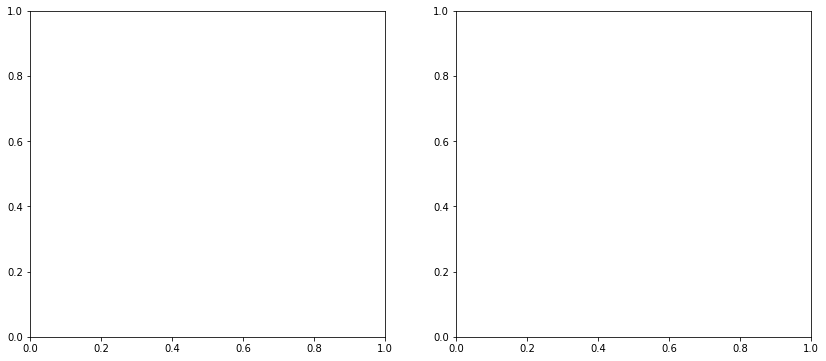

In [182]:
with plt.rc_context(rc_dct):
    for level, results in pinch_points_results.items():
        deck = utils.PdfDeck()
        plot_lockdown(results, deck, keys_to_plot)
        deck.make(os.path.join(chart_folder, f"{level}_pinch_points.pdf"))

# Test Trace Tables

In [185]:
tt_dir = os.path.join(os.environ['DATA'], "tti-explorer", "pinch-points-test-trace-delay")
test_trace_results = defaultdict(lambda: defaultdict(list))
for lockdown, target, cfg, results in resgen(tt_dir):
    if int(lockdown[1]) > 0:
        vals = [cfg[k] for k in target]
        level, measures = lockdown.split('_', maxsplit=1)
        test_trace_results[level][measures].append((vals, results))  

In [186]:
strings = list()
t1, t2 = ['Test Delay (days)', 'Manual Trace Delay (days)']
table_deck = utils.LatexTableDeck()

for k in sorted(test_trace_results.keys()):
    table_deck.add_section(f"Lockdown Level {k}")
    for policy, entry in test_trace_results[k].items():
        df = make_table(entry, key=keys_to_plot[0])
        df.index =  range(1, 4)
        df.columns = range(1, 4)
        df.index.name = t1
        df.columns.name = t2
        table_deck.add_table(
            tex_table=df.applymap(lambda x: f"{x:.2f}").to_latex(),
            caption=nice_lockdown_name(policy)
        )
    table_deck.clearpage()
table_deck.make("test-trace-tables.tex")


KeyError: 'Effective R'

# Sensitivity

In [40]:
case_sensitivity_results = defaultdict(dict)
case_sensitivity_dir = os.path.join(os.environ['DATA'], 'tti-explorer', 'case-sensitivity')
for lockdown, target, cfg, results in resgen(case_sensitivity_dir):
    if lockdown == "L0": 
        continue
    level, measures = lockdown.split("_", maxsplit=1)
    case_sensitivity_results[level][measures] = pd.read_csv(
        os.path.join(case_sensitivity_dir, lockdown, "run_0.csv"),
        index_col=0
    )

### Latent period!

In [163]:
import config

class LockdownSensitivityPlotter:
    def __init__(self):
        vary_flu = [ 
        (
            f"{k}k SC-\n"
            f"{round(config.PROP_COVID_SYMPTOMATIC * 20)}k SC+\n"
            f"{round((1 - config.PROP_COVID_SYMPTOMATIC) * 20)}k AC+\n"
        )
            for k in [50, 100, 200, 300]
        ]

        vary_covid = [ 
            (
                f"{100}k SC-\n"
                f"{round(config.PROP_COVID_SYMPTOMATIC * k)}k SC+\n"
                f"{round((1 - config.PROP_COVID_SYMPTOMATIC) * k)}k AC+\n"
            )
                for k in [50, 100, 200, 300]
            ]

        inf_props_ticklabels = vary_flu
        inf_props_ticklabels.extend(vary_covid)
        inf_props_ticklabels.append(
            (f"100k SC-\n"
             f"{round(config.PROP_COVID_SYMPTOMATIC * 20)}k SC+\n"
             f"{round((1 - config.PROP_COVID_SYMPTOMATIC) * 20)}k AC+\n")
        )
        self.ticklabel_maps = {
            'inf_profile': np.array(["Earlier", "Moderate", "Later"]),
             'infection_proportions': np.array(inf_props_ticklabels),
             'p_day_noticed_symptoms': np.array(["Earlier", "Moderate", "Later"])[::-1],
        }
        self. param_map = {
                'oxteam_inf_profile11_seed0': 0,
                 'oxteam_inf_profile12_seed0': 1,
                 'oxteam_inf_profile13_seed0': 2,
                 'oxteam_infection_proportions0_seed0': 0,
                 'oxteam_infection_proportions1_seed0': 1,
                 'oxteam_infection_proportions2_seed0': 2,
                 'oxteam_infection_proportions3_seed0': 3,
                 'oxteam_infection_proportions4_seed0': 4,
                 'oxteam_infection_proportions5_seed0': 5,
                 'oxteam_infection_proportions6_seed0': 6,
                 'oxteam_infection_proportions7_seed0': 7,
                 'oxteam_p_day_noticed_symptoms10_seed0': 2,
                 'oxteam_p_day_noticed_symptoms8_seed0': 1,
                 'oxteam_p_day_noticed_symptoms9_seed0': 0
            }
    def grouper(self, s):  ## hack!
        l = s.split("_")[1:-1]
        string = "_".join(l)
        for i in range(10):
            string = string.replace(f"{i}", "")
        return string
        
    def __call__(self, results, deck, keys_to_plot):
        by_param = pd.concat(results, axis=0).groupby(level=1, by=self.grouper)
        for param_name, v in by_param:
            fig, axarr = plt.subplots(1, 2)
            for key, ax in zip(keys_to_plot, axarr.flat):
                for measure, srs in v[key].rename(self.param_map).groupby(level=0):
                    srs = srs.droplevel(0)
                    xaxis = srs.index.values
                    ax.scatter(srs.index.values, srs.values, label=nice_lockdown_name(measure))
                    ax.set_xticks(xaxis)
                    ax.set_xticklabels(self.ticklabel_maps[param_name][xaxis])
                ax.set_xlabel(nice_param_name(param_name), x=0)
                ax.set_ylabel(key)
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            ax.set_xlabel("")
            plt.subplots_adjust(wspace=0.05)
            legend(fig, ax)
            deck.add_figure(fig, name=param_name)
            

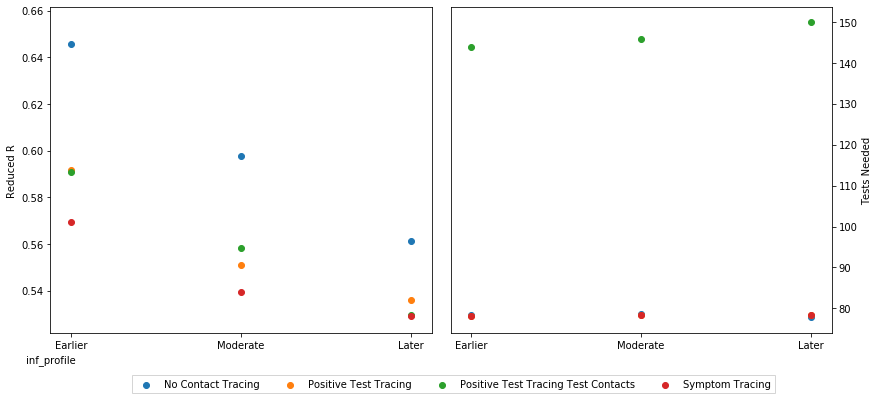

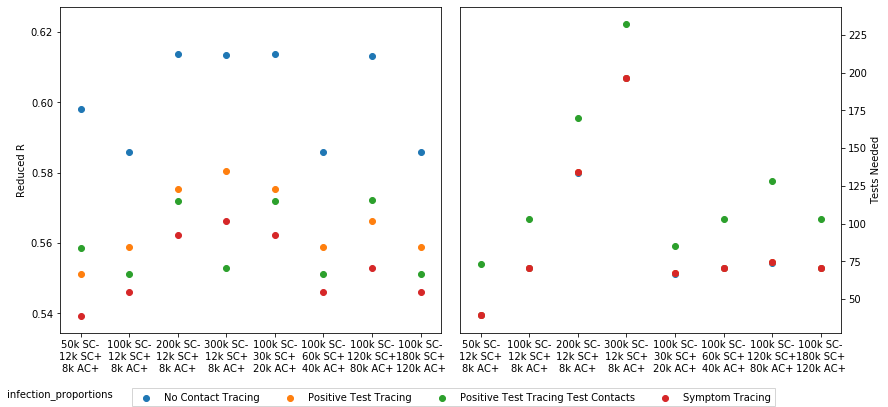

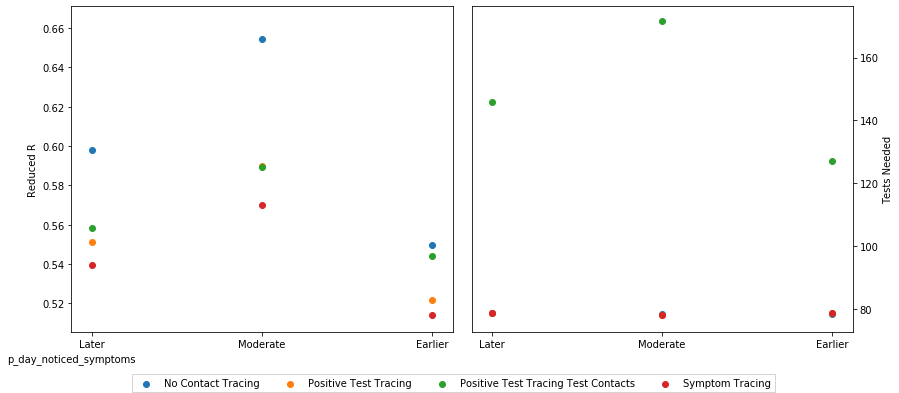

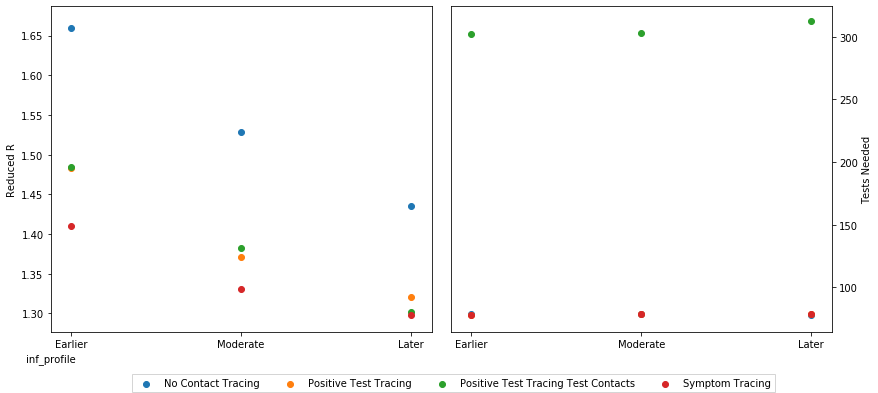

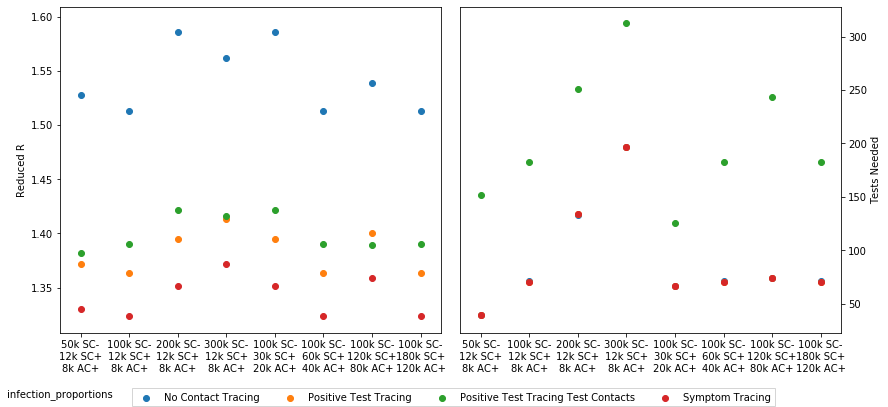

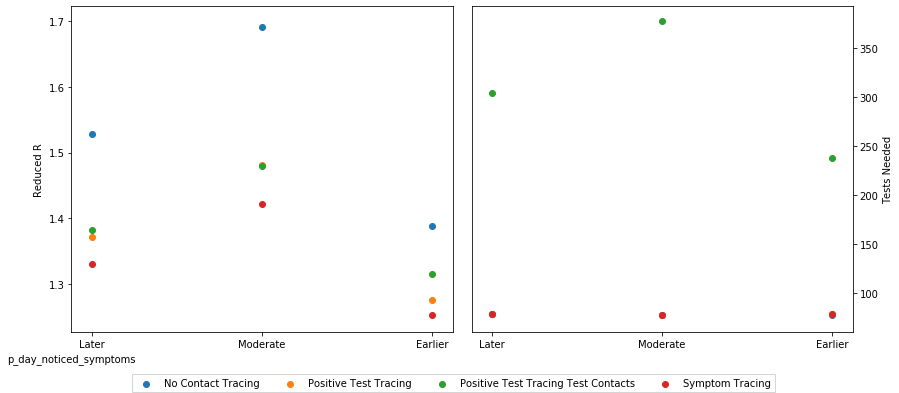

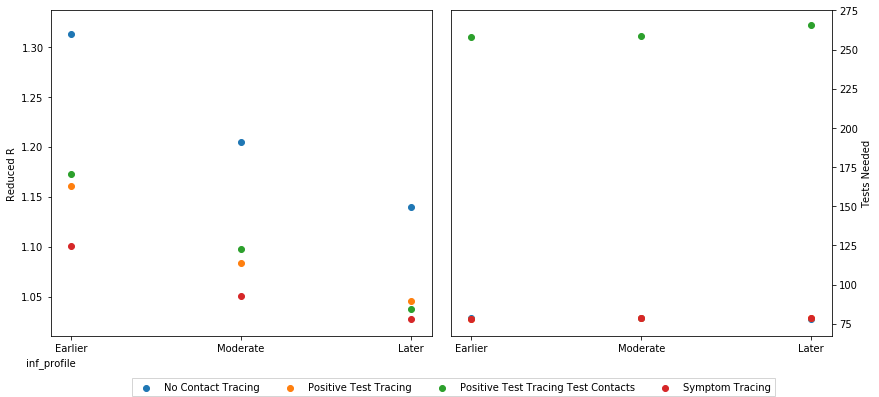

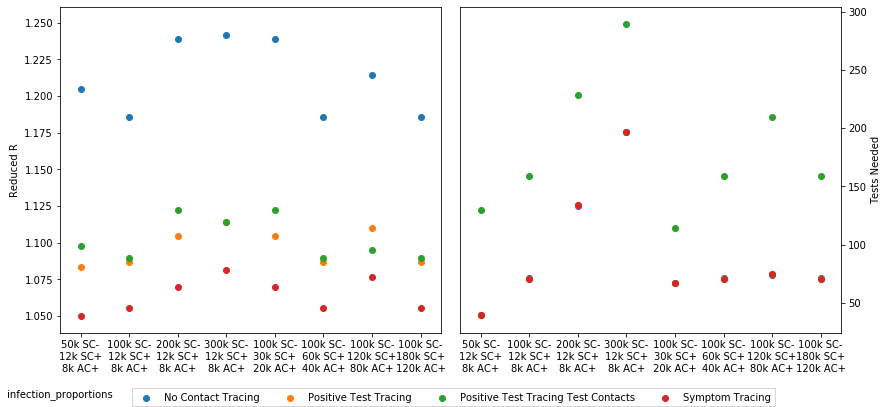

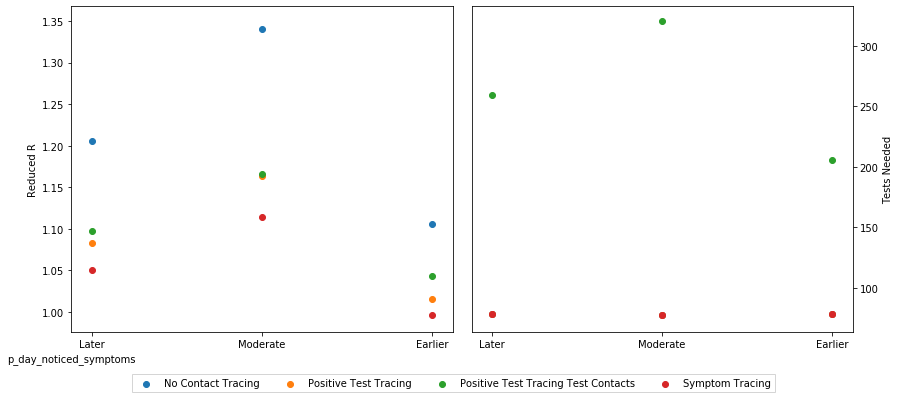

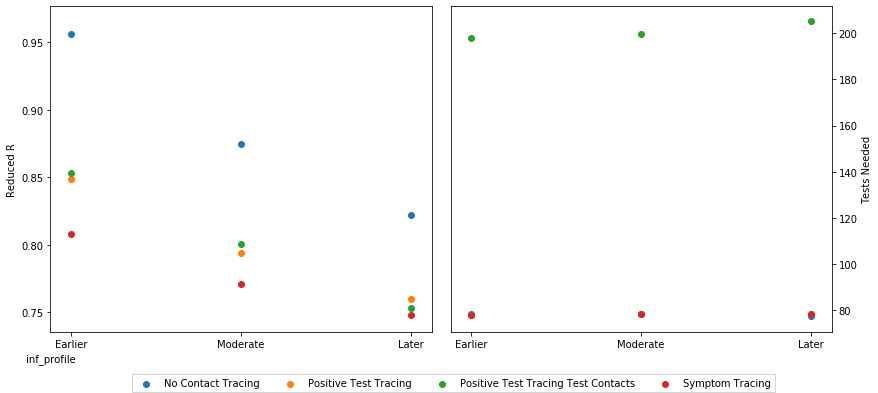

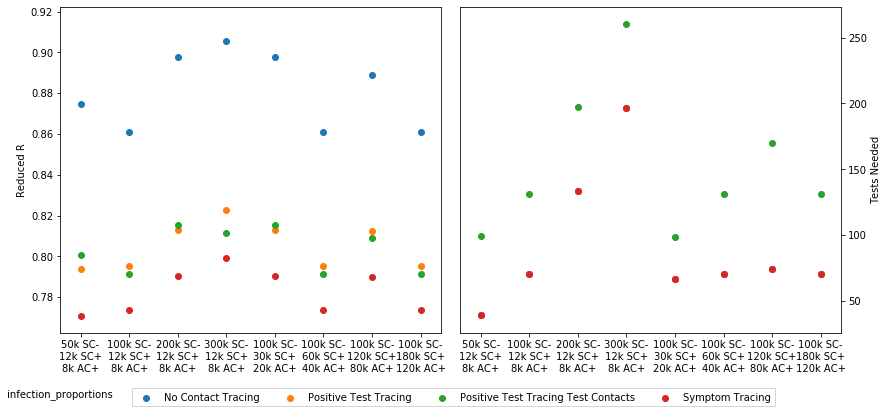

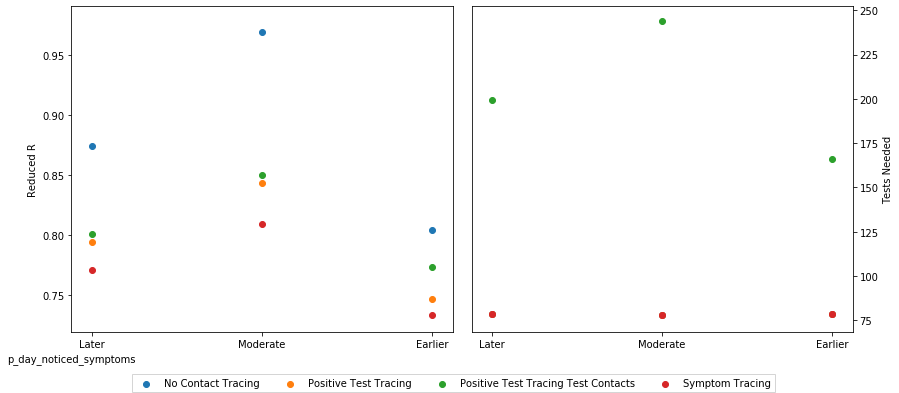

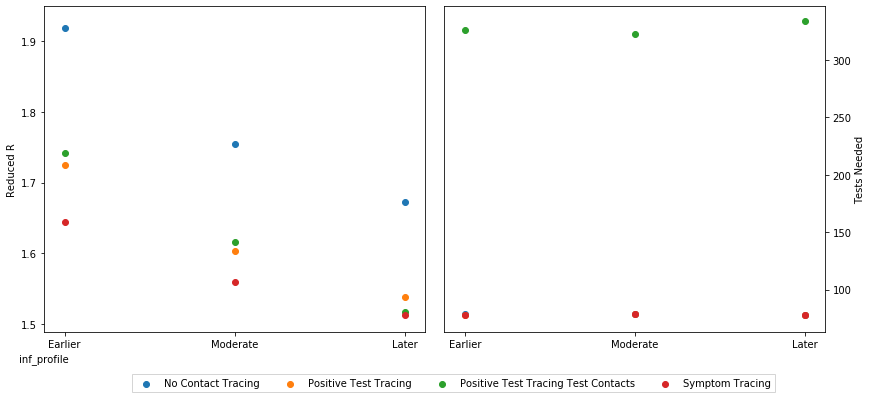

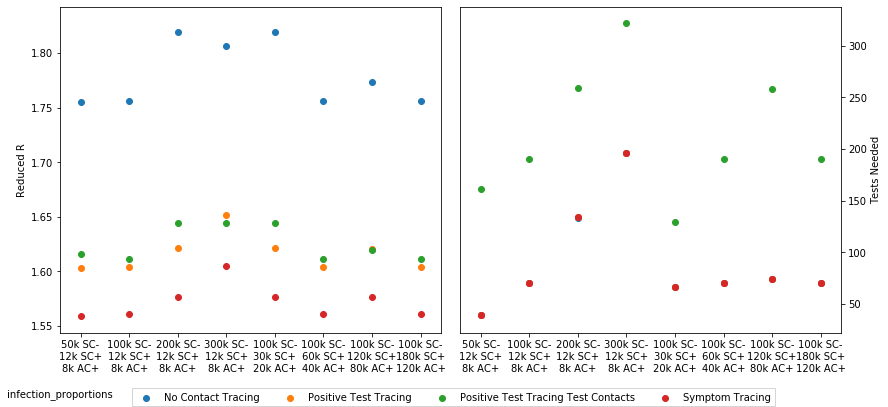

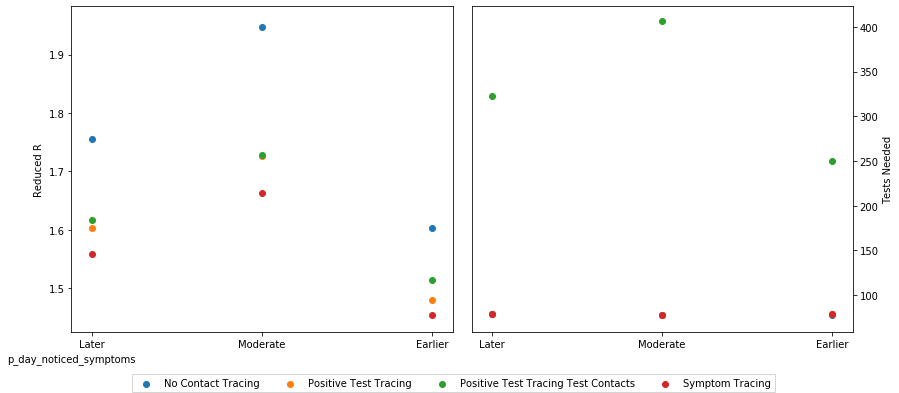

In [175]:
with plt.rc_context(rc_dct):
    plotter = LockdownSensitivityPlotter()
    for level, results in case_sensitivity_results.items():
        deck = PdfDeck()
        plotter(results, deck, keys_to_plot)
        deck.make(os.path.join(chart_folder, f"{level}_sensitivity.pdf"))
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)
#         by_param = pd.concat(results, axis=0).groupby(level=1, by=grouper)
#         for param_name, v in by_param:
#             param_names.append(param_name)
#             fig, axarr = plt.subplots(1, 2)
#             for key, ax in zip(keys_to_plot, axarr.flat):
#                 for measure, srs in v[key].rename(param_map).groupby(level=0):
#                     srs = srs.droplevel(0)
#                     xaxis = srs.index.values
#                     ax.scatter(srs.index.values, srs.values, label=nice_lockdown_name(measure))
#                     ax.set_xticks(xaxis)
#                     ax.set_xticklabels(ticklabel_maps[param_name][xaxis])
#                 ax.set_xlabel(nice_param_name(param_name), x=0)
#                 ax.set_ylabel(key)
#             ax.yaxis.set_label_position("right")
#             ax.yaxis.tick_right()
#             ax.set_xlabel("")
#             plt.subplots_adjust(wspace=0.05)
#             legend(fig, ax)